In [1]:
import tensorflow as tf
from keras.datasets import mnist, fashion_mnist, cifar10

import keras
from keras.layers import Layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

In [2]:
# Download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [16]:
X_train = X_train/255.
X_test = X_test/255.

In [17]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [112]:
class GDN(Layer):

    def __init__(self, 
                 filter_shape = (3,3),
                 **kwargs):
        
        self.filter_shape = filter_shape

        super(GDN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.beta = self.add_weight(name = 'beta', 
                                    shape = (input_shape.as_list()[-1]),
                                    initializer = tf.keras.initializers.constant(0.001),
                                    trainable = True)
        
        self.alpha = self.add_weight(name = 'alpha', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(2),
                                     trainable = True)

        self.epsilon = self.add_weight(name = 'epsilon', 
                                     shape = (input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.constant(0.5),
                                     trainable = True)
        
        self.gamma = self.add_weight(name = 'gamma', 
                                     shape = (self.filter_shape[0], self.filter_shape[1], input_shape.as_list()[-1], input_shape.as_list()[-1]),
                                     initializer = tf.keras.initializers.Ones, #'uniform',
                                     trainable = True)
        
        
        super(GDN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        norm_conv2 = tf.nn.convolution(tf.abs(x)**self.alpha,
                                      self.gamma,
                                      strides = (1, 1),
                                      padding = "SAME",
                                      data_format = "NHWC")
        print(norm_conv2.shape)

        norm_conv = self.beta + norm_conv2
        norm_conv = norm_conv**self.epsilon
        return x / norm_conv
        
    def compute_output_shape(self, input_shape):
        return (input_shape, self.output_dim)

In [113]:
# Modelo con GDN
model = Sequential()
model.add(GDN(input_shape = X_train.shape[1:4]))

(None, 28, 28, 1)


In [114]:
X_train.shape[1:4]

(28, 28, 1)

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_1 (GDN)                  (None, 28, 28, 1)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [21]:
X_train_out = model.apply(X_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [22]:
X_train_out.shape

TensorShape([60000, 28, 28, 1])

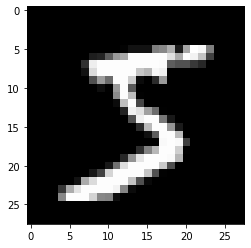

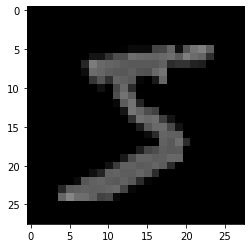

In [23]:
plt.imshow(tf.squeeze(X_train[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(X_train_out[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()

In [24]:
np.max(X_train_out[0])

0.5272389

In [27]:
from scipy import signal

In [31]:
test_1 = X_train[0][:,:,:]
print(np.matrix(test_1[15:20,15:20]), test_1.shape)
test_2 = test_1 ** [2]
print(np.matrix(test_2[15:20,15:20]), test_2.shape)
test_3 = signal.convolve(test_2, np.array([[1,1,1],[1,1,1],[1,1,1]]).reshape(3,3,1), mode = 'same', method = 'direct')
print(np.matrix(test_3[15:20,15:20]), test_3.shape)
test_4 = test_3 + 0.001
print(np.matrix(test_4[15:20,15:20]), test_4.shape)
test_5 = test_4 ** [0.5]
print(np.matrix(test_5[15:20,15:20]), test_5.shape)
test_6 = test_1 / test_5
print(np.matrix(test_6[15:20,15:20]), test_6.shape)

[[0.72941176 0.99215686 0.99215686 0.58823529 0.10588235]
 [0.0627451  0.36470588 0.98823529 0.99215686 0.73333333]
 [0.         0.         0.97647059 0.99215686 0.97647059]
 [0.50980392 0.71764706 0.99215686 0.99215686 0.81176471]
 [0.99215686 0.99215686 0.99215686 0.98039216 0.71372549]] (28, 28, 1)
[[0.53204152 0.98437524 0.98437524 0.34602076 0.01121107]
 [0.00393695 0.13301038 0.976609   0.98437524 0.53777778]
 [0.         0.         0.95349481 0.98437524 0.95349481]
 [0.25990004 0.5150173  0.98437524 0.98437524 0.65896194]
 [0.98437524 0.98437524 0.98437524 0.96116878 0.50940408]] (28, 28, 1)
[[4.53906959 5.80087659 5.62053057 4.06775855 1.88899654]
 [1.68450596 4.56784314 6.34663591 6.73173395 3.88024606]
 [0.944406   3.82634371 6.51563245 8.01783929 5.16641292]
 [3.58268358 5.66591311 7.35155709 7.97402537 5.11483276]
 [6.5358093  7.30248366 7.11294118 5.79753941 3.20753556]] (28, 28, 1)
[[4.54006959 5.80187659 5.62153057 4.06875855 1.88999654]
 [1.68550596 4.56884314 6.3476359

In [29]:
print(np.matrix(np.array(X_train_out[0][15:20,15:20,:]).reshape(5,5)))

[[0.34232727 0.41190407 0.41845915 0.29162192 0.07701814]
 [0.04832977 0.17062381 0.39224225 0.38237068 0.37223384]
 [0.         0.         0.38251418 0.3503681  0.42955878]
 [0.26930127 0.30146554 0.3658989  0.35132924 0.3588988 ]
 [0.38805872 0.36712614 0.3719848  0.40713695 0.39845362]]


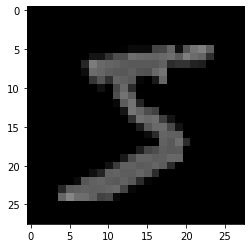

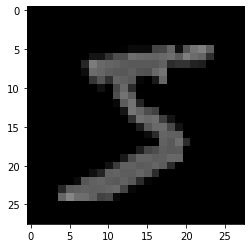

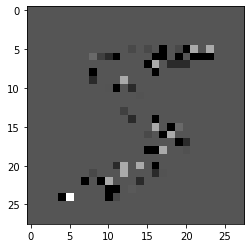

In [37]:
plt.imshow(test_6.reshape([28,28]), cmap = 'gray',vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(X_train_out[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()
plt.imshow(test_6.reshape([28,28])-tf.squeeze(X_train_out[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()

# Fashion MNIST

In [39]:
(X_train_f, y_train), (X_test_f, y_test) = fashion_mnist.load_data()

In [46]:
X_train_f = X_train_f.reshape(60000, 28, 28, 1)
X_test_f = X_test_f.reshape(10000, 28, 28, 1)

X_train_f = X_train_f/255.
X_test_f = X_test_f/255.

In [47]:
model_f = Sequential()
model_f.add(GDN(input_shape = X_train_f.shape[1:4]))
model_f.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_3 (GDN)                  (None, 28, 28, 1)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_f.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
model_f.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_3 (GDN)                  (None, 28, 28, 1)         12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [49]:
X_train_out_f = model_f.apply(X_train_f)
X_train_out_f.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


TensorShape([60000, 28, 28, 1])

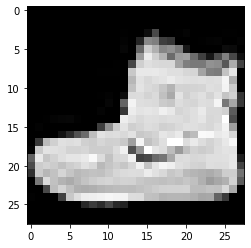

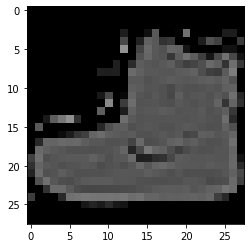

In [50]:
plt.imshow(tf.squeeze(X_train_f[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(X_train_out_f[0]), cmap = 'gray',vmin=0,vmax=1)
plt.show()

# CIFAR10

In [115]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [116]:
x_train = x_train.reshape(50000, 32, 32, 3)
x_test = x_test.reshape(10000, 32, 32, 3)

In [117]:
x_train = x_train/255.
x_test = x_test/255.

In [118]:
# Modelo con GDN
model_2 = Sequential()
model_2.add(GDN(input_shape = x_train.shape[1:4]))

(None, 32, 32, 3)


In [119]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

model_2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gdn_12 (GDN)                 (None, 32, 32, 3)         90        
Total params: 90
Trainable params: 90
Non-trainable params: 0
_________________________________________________________________


In [120]:
x_train_out = model_2.apply(x_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(50000, 32, 32, 3)


In [121]:
x_train_out.shape

TensorShape([50000, 32, 32, 3])

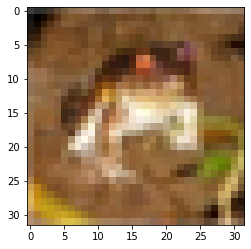

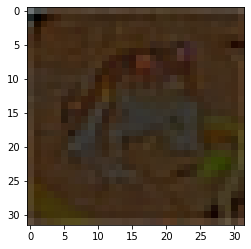

In [123]:
plt.imshow(tf.squeeze(x_train[0]),vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(x_train_out[0]),vmin=0,vmax=1)
plt.show()

In [124]:
prueba = x_train[0][:3,:3,:]
print(prueba)
alpha = [2,2,1]
print(prueba**alpha)
beta = [0.001, 0.1, 0.5]
print(prueba**alpha + beta)
epsilon = [0.5, 1, 0]
print((prueba**alpha + beta)**epsilon)

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]]]
[[[0.05353326 0.05911572 0.24705882]
  [0.02843522 0.03254133 0.17647059]
  [0.03844675 0.03543253 0.16862745]]

 [[0.00393695 0.00615148 0.07843137]
  [0.         0.         0.        ]
  [0.0049827  0.00098424 0.        ]]

 [[0.00961169 0.00885813 0.08235294]
  [0.00393695 0.00075356 0.        ]
  [0.03692426 0.01121107 0.03137255]]]
[[[0.05453326 0.15911572 0.74705882]
  [0.02943522 0.13254133 0.67647059]
  [0.03944675 0.13543253 0.66862745]]

 [[0.00493695 0.10615148 0.57843137]
  [0.001      0.1        0.5       ]
  [0.0059827  0.10098424 0.5       ]]

 [[0.01061169 0.10885813 0.58235294]
  [0.00493695 0.10075356 0.5       ]
  [0.03792426 0.111211

## Ponemos los pesos a mano

In [125]:
W=model_2.get_weights()

In [126]:
W

[array([0.001, 0.001, 0.001], dtype=float32),
 array([2., 2., 2.], dtype=float32),
 array([0.5, 0.5, 0.5], dtype=float32),
 array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]], dtype=float32)]

In [127]:
W2 = W

In [128]:
W2[3] = np.zeros((3,3,3,3)) 

In [129]:
#W2[3][0,0,1,1] = 1
#W2[3][1,1,1,1] = 1
#W2[3][2,2,1,1] = 1
W2[0] = np.array([1,1,1],dtype=np.float32)
W2

[array([1., 1., 1.], dtype=float32),
 array([2., 2., 2.], dtype=float32),
 array([0.5, 0.5, 0.5], dtype=float32),
 array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])]

In [131]:
model_2.set_weights(W2)

In [132]:
W3 = model_2.get_weights()
W3

[array([1., 1., 1.], dtype=float32),
 array([2., 2., 2.], dtype=float32),
 array([0.5, 0.5, 0.5], dtype=float32),
 array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], dtype=float32)]

In [133]:
x_train_out = model_2.apply(x_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2215: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(50000, 32, 32, 3)


In [135]:
x_train_out.shape

TensorShape([50000, 32, 32, 3])

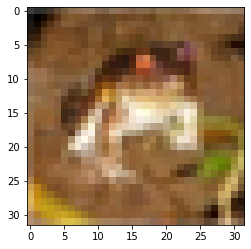

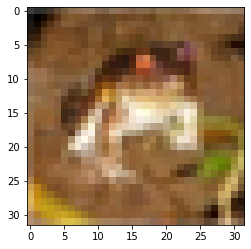

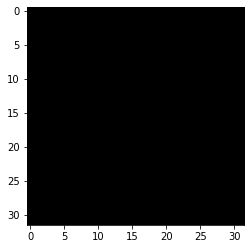

In [140]:
plt.imshow(tf.squeeze(x_train[0]),vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(x_train_out[0]),vmin=0,vmax=1)
plt.show()
plt.imshow(tf.squeeze(x_train[0]-x_train_out[0]))#,vmin=0,vmax=1)
plt.show()